<a href="https://colab.research.google.com/github/azkbrqlna/2025-ComputerVision/blob/main/Jobsheet3_RegresiGambar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Praktikum D1 - Prediksi Radius Lingkaran

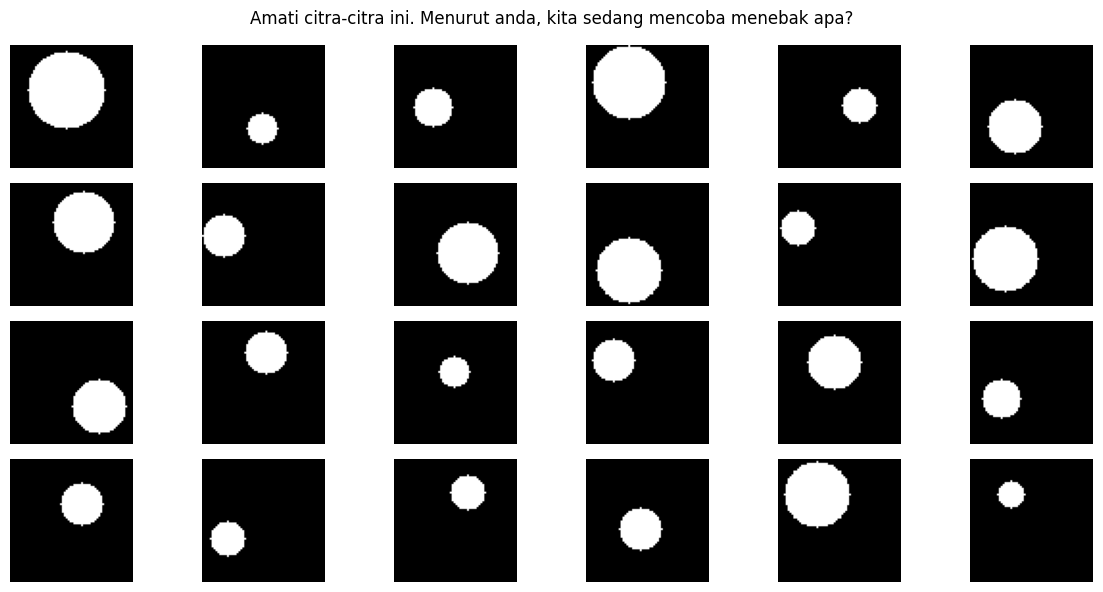

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras import layers, models


def make_sample(img_size=64, min_r = 5, max_r=20):
  r = np.random.randint(min_r, max_r + 1) # radius acak
  img = np.zeros((img_size, img_size), dtype=np.uint8)
  cx = np.random.randint(r, img_size - r) # center-x
  cy = np.random.randint(r, img_size - r) #center-y
  cv2.circle(img, (cx, cy), int(r), (255,), -1)
  img = (img / 255.0).astype(np.float32)
  # 3 channel biar kompatibel CNN
  img3 = np.stack([img, img, img], axis=-1)
  return img3, float(r), (cx, cy)



N_show = 24
samples = [make_sample() for _ in range(N_show)]
imgs = [s[0] for s in samples]
rads = [s[1] for s in samples]
centers = [s[2] for s in samples]

cols = 6
rows = N_show // cols
plt.figure(figsize=(12,6))
for i in range(N_show):
    plt.subplot(rows, cols, i+1)
    plt.imshow(imgs[i].squeeze(), cmap='gray')
    plt.axis('off')
plt.suptitle("Amati citra-citra ini. Menurut anda, kita sedang mencoba menebak apa?")
plt.tight_layout()
plt.show()




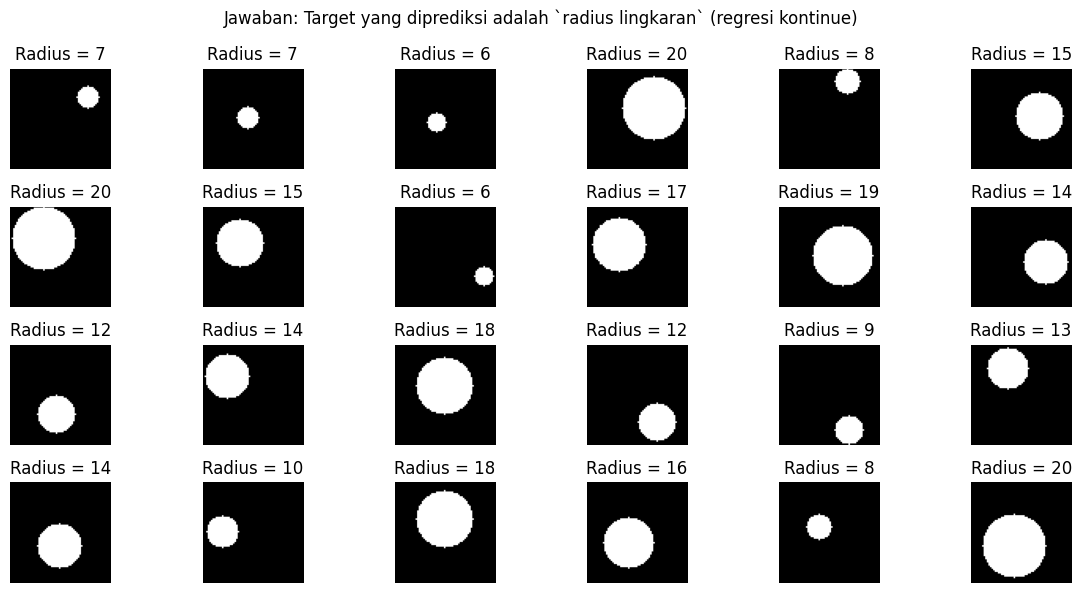

In [7]:
plt.figure(figsize=(12, 6))
for i in range(N_show):
  plt.subplot(rows, cols, i+1)
  plt.imshow(imgs[i].squeeze(), cmap='gray')
  plt.title(f"Radius = {int(rads[i])}")
  plt.axis('off')

plt.suptitle("Jawaban: Target yang diprediksi adalah `radius lingkaran` (regresi kontinue)")
plt.tight_layout()
plt.show()

In [9]:
N = 3000
X, y, C = zip(*[make_sample() for _ in range(N)])
X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.float32)

Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=42)

# Model CNN sederhana
model = models.Sequential([
    layers.Input((64,64,3)),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
history = model.fit(Xtr, ytr, validation_data=(Xte, yte),
epochs=12, batch_size=64, verbose=0)

y_pred = model.predict(Xte).ravel()
mae = mean_absolute_error(yte, y_pred)
rmse = float(np.sqrt(np.mean((yte - y_pred)**2)))
r2 = r2_score(yte, y_pred)

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


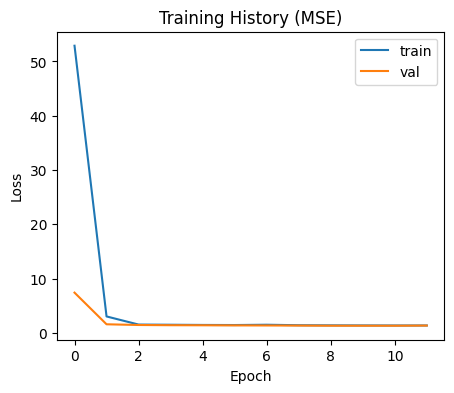

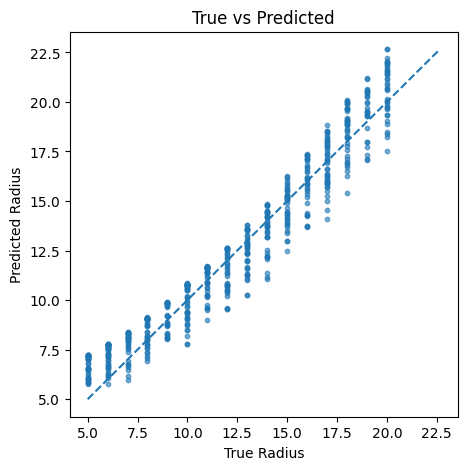

In [19]:
plt.figure(figsize=(5,4))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title("Training History (MSE)")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.show()

plt.figure(figsize=(5,5))
plt.scatter(yte, y_pred, s=10, alpha=0.6)
lims = [min(yte.min(), y_pred.min()), max(yte.max(), y_pred.max())]
plt.plot(lims, lims, '--')
plt.xlabel("True Radius"); plt.ylabel("Predicted Radius")
plt.title("True vs Predicted")
plt.show()

## Praktikum D2 - Menebak Umur Manusia dari Foto Wajah (UTKFace)

In [20]:
from google.colab import files
files.upload() # pilih kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"azkabariqlana","key":"91e048f00028be3d94996f30f8d635bb"}'}

In [23]:
import os, shutil
if os.path.exists("kaggle.json"):
  os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
  shutil.copy("kaggle.json", os.path.expanduser("~/.kaggle/kaggle.json"))
  !pip -q install kaggle
  print("Kaggle API siap digunakan")
else:
  print("Kaggle API tidak ditemukan")

Kaggle API siap digunakan


In [24]:
!kaggle datasets download -d jangedoo/utkface-new -p /content -q
!unzip -q /content/utkface-new.zip -d /content/utk
print("Dataset UTKFace berhasil diekstrak")

Dataset URL: https://www.kaggle.com/datasets/jangedoo/utkface-new
License(s): copyright-authors
Dataset UTKFace berhasil diekstrak


Total gambar ditemukan: 23708


<function matplotlib.pyplot.show(close=None, block=None)>

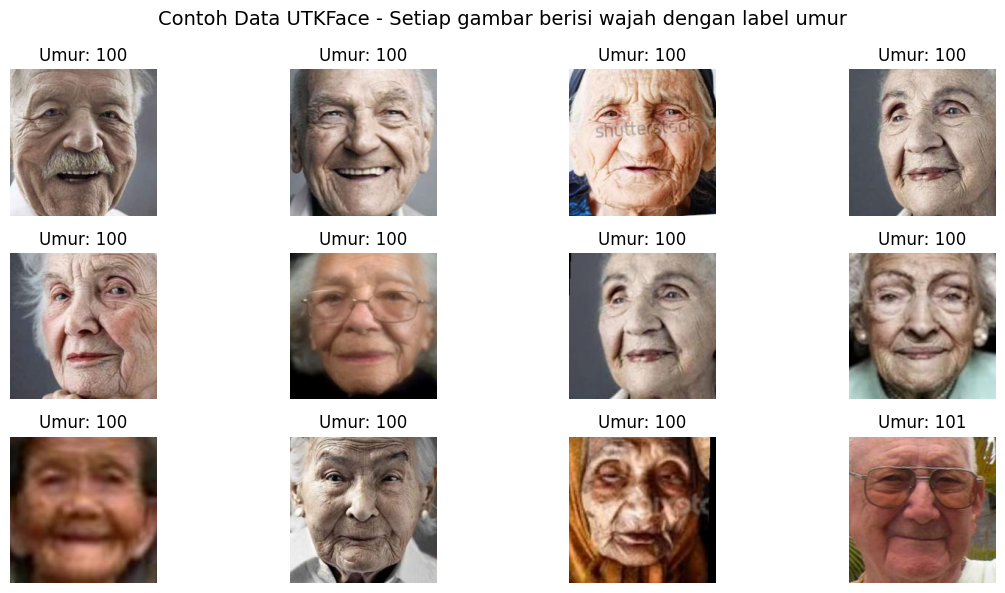

In [27]:
import matplotlib.pyplot as plt
import os, glob
from PIL import Image

files = glob.glob("utk/UTKFace/*.jpg")
files = sorted(files)
print(f"Total gambar ditemukan: {len(files)}")

plt.figure(figsize=(12, 6))
for i, f in enumerate(files[:12]):
  age = int(os.path.basename(f).split("_")[0])
  img = Image.open(f)
  plt.subplot(3, 4, i+1)
  plt.imshow(img)
  plt.title(f"Umur: {age}")
  plt.axis("off")

plt.suptitle("Contoh Data UTKFace - Setiap gambar berisi wajah dengan label umur", fontsize=14)
plt.tight_layout()
plt.show